


<div class="alert alert-block alert-info">
A Notebook for Predicting a Multi-Class, Ordinal Target Variable
</div>
__________________________________________________________________________________

This Notebook will go through the following steps:



1. Data Check and Exploration <br>
a. Check for missing/nan values <br>
b. Check that data is normalized<br>
c. View class distributions<br>
d. Calculate variance inflation factors
e. Chart correlation coeffecients
2. Model Preparation and Execution<br>
a. Class weights, asymetrical loss function<br>
b. Baseline - Random Forest
c. XGBoost
3. Summary Evaluation

In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

<div class="alert alert-block alert-info">
1. Data Check and Exploration
</div>

In [2]:
#read in data

train_df = pd.read_csv(r"C:\Users\\Downloads\train.csv")
test_df = df = pd.read_csv(r"C:\Users\\Downloads\test (1).csv")

<div class="alert alert-block alert-warning">
We can now begin to explore the data. First, we will write a funcition to return some summary bits of the train data that we can reuse later if need be
</div>

In [8]:
#define function to check for missing/nan values; check for normalized data; view class distribution

def data_check(df, target):
    
    #define function to check for missing/null values
    def null_nan(df):
        report = df.isna().sum()#check for null values
        arr = np.array(report)#convert report to array
        arr_sum = sum(arr)#sum null value
        
        print("--Null values report--")
        print(report)
        
        if arr_sum==0:
            print('Looks good! No nulls or missing values')
        else:
            print('found nulls . . .')
            
    null_nan(df)

    #define funciton to plot class distributions for target class
    def pct_class(df, target):
        chart_class = pd.value_counts(train_df['label'], normalize = True).plot.bar(title = 'Unique label values by percentage')
        return chart_class
    
    pct_class(df, target)
    
    def check_norm(df):
        check_df = np.array(df.iloc[: , :-1])
        max_high = np.max(check_df)
        min_low = np.min(check_df)
        print("\n")
        print("\n")
        print("--Normalization Report--")
        if max_high <= 1 and min_low >= 0:
            
            print('Normalized')
        else:
            print('Not Normalized')
            
    check_norm(df)

In [5]:
#separate labels from variables in training data for check
train_var = train_df.iloc[: , :-1]

--Null values report--
x1    0
x2    0
x3    0
x4    0
x5    0
x6    0
y1    0
z1    0
z2    0
z3    0
z4    0
dtype: int64
Looks good! No nulls or missing values




--Normalization Report--
Normalized


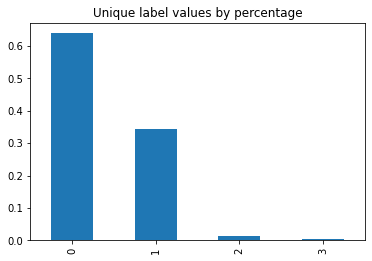

In [9]:
#run 'data_check' funciton and view results
train_check = data_check(train_var, train_df['label'])
train_check

<div class="alert alert-block alert-warning">
The train dataset looks like it is normalized and with no missing or nan value. The class distribution shows a significant class imbalance which we may need to address later on. 

Below, we will run the same set of analyses, sans the class distribution, for the test data set:
</div>

In [133]:
#check for missing/null values and normalzied data in 'test_df'

#define normalized funciton to check test data
def norm(df):
    test_arr = np.array(df)
    test_high = np.max(test_arr)
    test_low = np.min(test_arr)

    if test_high <= 1 and test_low >= 0:
        print('Normalized')
    else:
        print('Not Normalized')

#run check for null/missing values and normalized data on 'test_df'
null_nan(train_df)
norm(test_df)


Missing values
x1       0
x2       0
x3       0
x4       0
x5       0
x6       0
y1       0
z1       0
z2       0
z3       0
z4       0
label    0
dtype: int64
looks good!
Normalized


<div class="alert alert-block alert-warning">
The test data set looks similar to the train data set so we are ok to proceed
</div>

<div class="alert alert-block alert-warning">
Let's do one more check of the data. Because we will be training our model on one data set and applying that model to another, it is important to understand whether or not the independent variables are sampled from the same distributions. If not, if my not be appropriate to expect a model with low variance
        
To do this we will apply two-sampled Kolmogorov-Smirnov test between each column in the training dataset and it's corresponding column in the test data set. The K-S test is performed on empirical distributions and calculates the distance between culumative distribution functions
</div>

In [52]:
from scipy import stats
from scipy.stats import kstest

df1_input = train_df.iloc[: , :-1]
df2_input = test_df

i = 0
while i in range(len(test_df.columns)):
    df1 = df1_input.iloc[:, i]
    df2 = df2_input.iloc[:,i]
    ks_test = kstest(df1, df2, alternative='two-sided')
    print(str(i) +'th index = ' + str(ks_test) )
    i += 1

0th index = KstestResult(statistic=0.005060000000000009, pvalue=0.7849552075425148)
1th index = KstestResult(statistic=0.005309999999999981, pvalue=0.7330649578909233)
2th index = KstestResult(statistic=0.006549999999999945, pvalue=0.47004441389165075)
3th index = KstestResult(statistic=0.005849999999999966, pvalue=0.6161919318352537)
4th index = KstestResult(statistic=0.006159999999999999, pvalue=0.5497694682463621)
5th index = KstestResult(statistic=0.005029999999999979, pvalue=0.790986979318294)
6th index = KstestResult(statistic=0.00902, pvalue=0.1319629467132334)
7th index = KstestResult(statistic=0.0046199999999999575, pvalue=0.8672741548894244)
8th index = KstestResult(statistic=0.0040599999999999525, pvalue=0.945315419400635)
9th index = KstestResult(statistic=0.005259999999999987, pvalue=0.7436396117980495)
10th index = KstestResult(statistic=0.005219999999999947, pvalue=0.752037363299729)


<div class="alert alert-block alert-warning">
The relatively large p-values above as function of the test statistic indicate that we do not have sufficient evidence to reject the null hypothesis that all samples arise from the same distribution. This means that the training and test data should be similar enough to expect low variance in any model we apply. Or rather, if there is high variance it shouldn't be attributable to the distribution of independent variables
</div>

<div class="alert alert-block alert-warning">
Next, we will look at the variance inflation factors (VIF) for each independent variable. The VIF is basically an adjusted form of R^2 and tells us how well each variable correlates with the others. Ideally, we would like to see a VIF of less than 10 which would indicate a lack of multicolinearity. 
</div>

In [171]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#independent variables set
X = train_df.iloc[: , :-1]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

   feature         VIF
0       x1  153.856155
1       x2  113.184034
2       x3   50.675056
3       x4  150.752039
4       x5  264.602993
5       x6   32.532279
6       y1    4.364131
7       z1    1.169360
8       z2    2.765024
9       z3   19.810702
10      z4   28.244596


<div class="alert alert-block alert-warning">
Above, we see many of the variabls have a high VIF. Let's dig a bit deeper and plot the a correlation matrix for each varialbe
</div>

<div class="alert alert-block alert-warning">
Many of the variables appear to be highly correlated. This may or may not be an issue. For the moment, as we concentrate on prediction, we will leave the variables as is. If we want to learn more about the cause and effect relationship between certain variables and the labels we will need to address the issue.
</div>

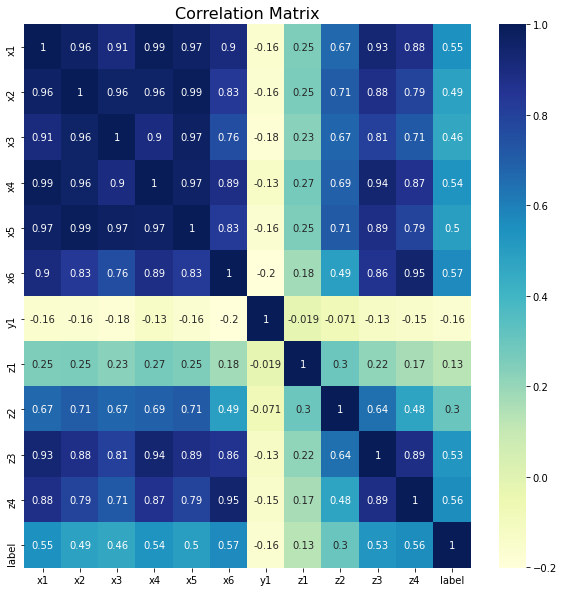

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = train_df
df = pd.DataFrame(data,columns=train_df.columns)

corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corrMatrix, annot=True, ax=ax, cmap="YlGnBu")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

<div class="alert alert-block alert-info">
2. Model Preparation and Execution: Random Forest
</div>

<div class="alert alert-block alert-warning">
Before we move into the modeling step let's add a random variable to the dataset. If we look at the importance factor for each variable, the random variable will act like a tracer setting a threshold below which the variables that fall aren't contributing to our output
</div>

In [66]:
#add random variable to 'train_df'
import random
data = np.random.randint(0,10,size=(len(train_df),1))
train_df.insert(0, 'rand_var', data)

<div class="alert alert-block alert-warning">
Let's separate our 'training' data set into a train and test(validation) set. We will start with an stratified 80/20 split set up so that the class distribution between the training and test sets are the same
</div>

In [67]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[: , :-1]
#X = train_df.loc[:,['x1', 'x2', 'x3', 'x4', 'x5', 'x6']]
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

<div class="alert alert-block alert-warning">
We may end up not using this but let's go ahead and upsample the imbalanced classes so that our data is balanced. Ideally, we would like to treat the imbalance through algorithmic weighting as SMOTE has a tendency to create noisy data. 
When doing this we need to make sure we only upsample the training data so that we do not leak data into our validation data
</div>

In [68]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

np.unique(y_train_smote, return_counts = True)


(array([0, 1, 2, 3], dtype=int64),
 array([51127, 51127, 51127, 51127], dtype=int64))

<div class="alert alert-block alert-warning">
Since we are going to be trying a few models let's go ahead and store our data in numpy arrays in a dictionary
</div>

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
#store data, all in numpy arrays
training_data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_test,'y_test':y_test}

<div class="alert alert-block alert-warning">
The first thing we might want to do is to construct a baseline model. Random will be a good start to give us a foundation 
against which to compare future models
</div>

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_jobs=None,random_state=42, verbose=1)
clf.fit(training_data['X_train'], training_data['y_train'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.4s finished


RandomForestClassifier(random_state=42, verbose=1)

<div class="alert alert-block alert-warning">
Below we will use our Random Forest model to predict the labels in our training and test sets. To gauge our results we look at accuracy for an overall feel of how our model is performing; F1 score to 'split the difference' between precision and recall; and we look at how the model predicts for each individual class
</div>

In [99]:
train_pred = clf.predict(training_data['X_train'])
predicted_labels = clf.predict(training_data['X_test'])
accuracy_score(training_data['y_test'], predicted_labels)


print('Train Accuracy:'+str(accuracy_score(training_data['y_train'], train_pred)))
print('Train F1-Score(Macro):'+str(f1_score(training_data['y_train'], train_pred,average='macro')))
print('------')
print('Test Accuracy:'+str(accuracy_score(training_data['y_test'], predicted_labels)))
print('Test F1-Score(Macro):'+str(f1_score(training_data['y_test'], predicted_labels,average='macro')))

print(classification_report(training_data['y_test'], predicted_labels))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train Accuracy:0.9999625
Train F1-Score(Macro):0.9999790001050486
------
Test Accuracy:0.8635
Test F1-Score(Macro):0.45281292698459036
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     12781
           1       0.76      0.89      0.82      6861
           2       0.33      0.03      0.06       287
           3       0.17      0.01      0.03        71

    accuracy                           0.86     20000
   macro avg       0.55      0.45      0.45     20000
weighted avg       0.86      0.86      0.86     20000



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


<div class="alert alert-block alert-warning">
The model certainly isn't terrible but the predictions for class 0 and 1 are doing the heavy lifting. A confusion matrix will give us additional insight into where the models is getting turned around
</div>

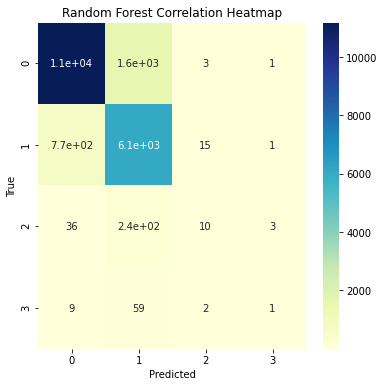

In [92]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

CM = confusion_matrix(y_test, predicted_labels)

# Visualize it as a heatmap
import seaborn

ax = plt.axes()
sns.heatmap(CM, cmap="YlGnBu", annot=True, ax = ax)

ax.set_title('Random Forest Correlation Heatmap')
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.show()


<div class="alert alert-block alert-warning">
Class 2 and 3 are sort of all over the place. Not great, especially that they are prone to underprediction. Let's take a look at one more visual. A confusion matrix let's us know how 'important' each feature is by running with model both with and without it and comparing the results; specifically the Gini impurity, or information gain, for each inernal node. However, we know that our features are heavily correlated so take this with a grain of salt. Below, we see that all the featues are at least more important than our random tracer
</div>

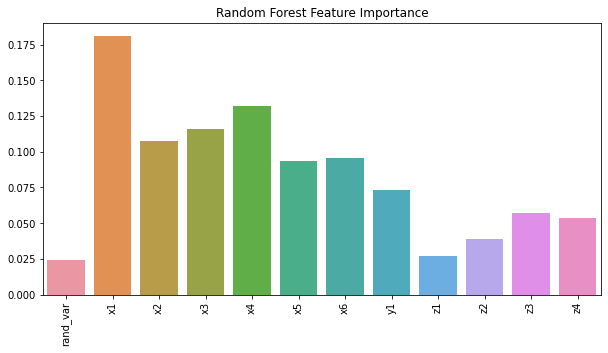

In [91]:
#plot feature importance

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=X_train.columns, y=clf.feature_importances_)
ax.set_title('Random Forest Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

<div class="alert alert-block alert-info">
2. Model Preparation and Execution: XGBoost
</div>

<div class="alert alert-block alert-warning">
Now that we have a baseline let's see how a model with more available complexity like XGBoost and one which should do a better job on our unbalanced data set by learning from it's mistakes instead of potentially propogating error like Random Forest. 
Below we have two functions that will; 1) compare the learning curves for the testing vs. training data for the loss and error. In this case, log loss should provide a good multiclass objective function for model learning because it takes into account the prior probability of encountering the class from the sample population
</div>

In [222]:
import xgboost as xgb
import matplotlib.pyplot as plt

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=900):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['y_train'])
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    val = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
   
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['y_test'],average='micro')))
    
     
    plot_compare(metrics,store,epochs)
    features = X_train.columns
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('XGBoost Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()


In [112]:
#define the parameters of our XGBoost classifier

from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=4,
                    seed=27)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.26867	val-merror:0.2372	train-mlogloss:1.26801	train-merror:0.231912
[100]	val-mlogloss:0.442032	val-merror:0.2134	train-mlogloss:0.420191	train-merror:0.20145
[200]	val-mlogloss:0.429811	val-merror:0.20275	train-mlogloss:0.387904	train-merror:0.177425
[300]	val-mlogloss:0.420924	val-merror:0.19335	train-mlogloss:0.360921	train-merror:0.158138
[399]	val-mlogloss:0.415413	val-merror:0.1881	train-mlogloss:0.339728	train-merror:0.144488
-- Model Report --
XGBoost Accuracy: 0.8319
XGBoost F1-Score (Micro): 0.8319


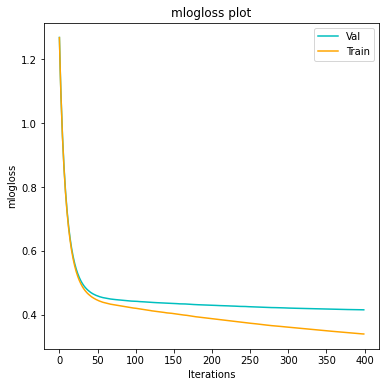

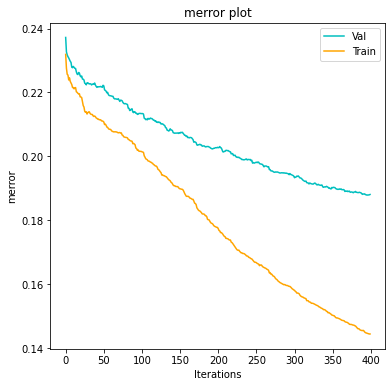

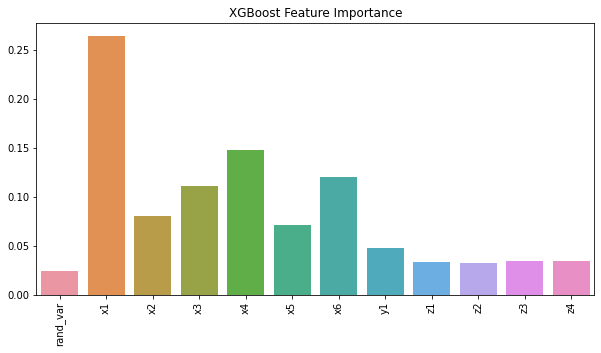

In [113]:
#fit our model with the 'fitXgb' funciton above which will give us some nice outputs

fitXgb(xgb1, training_data)

In [114]:
predicted_labels = xgb1.predict(training_data['X_test'])
    
print(classification_report(training_data['y_test'], predicted_labels))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87     12781
           1       0.71      0.88      0.78      6861
           2       0.33      0.02      0.04       287
           3       0.29      0.03      0.05        71

    accuracy                           0.83     20000
   macro avg       0.56      0.44      0.44     20000
weighted avg       0.84      0.83      0.83     20000



<div class="alert alert-block alert-warning">
Our first XGBoost model is certainly better than our Random Forest baseline matter; however, it's still not doing great on our imbalanced classes. Additionally, the feature importance plot shows us that we may need to employ a bit of regularization given how important x1 is compared the other variables. Let's take a look at the confustion matrix for the test and train data
</div>

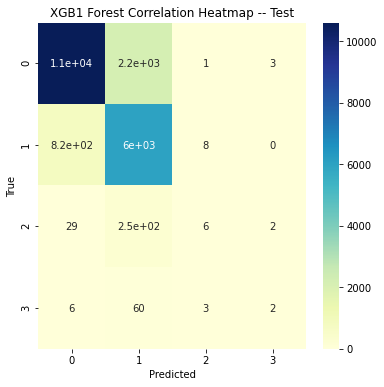

In [115]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test = training_data['y_test']
predicted_labels = xgb1.predict(training_data['X_test'])

CM = confusion_matrix(y_test, predicted_labels)

# Visualize it as a heatmap
import seaborn
ax = plt.axes()
sns.heatmap(CM,  cmap="YlGnBu", annot=True)

ax.set_title('XGB1 Forest Correlation Heatmap -- Test')
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.show()

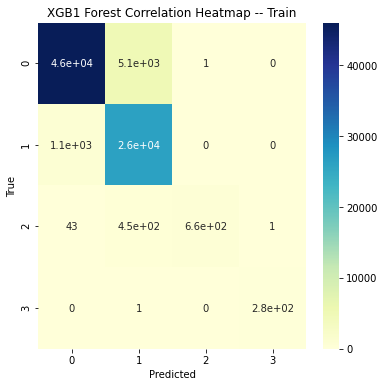

In [117]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test = training_data['y_train']
predicted_labels = xgb1.predict(training_data['X_train'])

CM = confusion_matrix(y_test, predicted_labels)

# Visualize it as a heatmap
import seaborn
ax = plt.axes()
sns.heatmap(CM,  cmap="YlGnBu", annot=True)

ax.set_title('XGB1 Forest Correlation Heatmap -- Train')
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.show()

<div class="alert alert-block alert-warning">
The training confusion matrix looks much better than the test confusion matrix which means that our model may be overfitting a bit. Also, looking at the loss curves we could stand to add some additional training epochs. 
*Note, given more time we would try to optimize our parameters using something like Grid Search CV. However, time and computational limits mean we need to some manual tuning
</div>

<div class="alert alert-block alert-warning">
One last thing before tuning; let's see how our model does on the holdout test data. Because we don't know the true labels of that data set we can't know the true performance; however, we can look compare the class distributions of both the training and test data to see if they are significantly different on a global level. We do this using the Kubllbac-Leibler Divergence via the entropy function from scipy.stats
</div>

In [199]:
#predict on test data and sample y_test data so lengths are equal
predict_on_test = xgb1.predict(training_data['X_test'])
y_train_sample = np.random.choice(training_data['y_test'], (20000,))

#hold data above as separate arrays
arr1 = predict_on_test
arr2 = y_train_sample

#convert zeros to 0.1 for entropy calculation. Otherwise 'inf' will be returned
result1 = np.where(arr1<=0, 0.1, arr1)
result2 = np.where(arr2<=0, 0.1, arr2)

#calculate entorpy
print('Entropy = ' + "" + str(entropy(result1, result2)))

Entropy = 1.1047197508609863


<div class="alert alert-block alert-warning">
The entropy here will be used as a relative metric as we try to improve our model; however, because it is not zero, or close to it, we can infer that there is a difference between the discrete, empirical distribution of classes in our training predictions and those predicted from our holdout test data
</div>

<div class="alert alert-block alert-warning">
Let's run another XGBoost model except this time let's increase the epochs; tune gamma up a bid as well as lambda; this should give us an equivalent of L1(lasso) and L2(ridge) regularization. 
</div>

In [205]:
from xgboost.sklearn import XGBClassifier
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1200,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=4,
                    lamda=3,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=4,
                    seed=27)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.26875	val-merror:0.23715	train-mlogloss:1.26803	train-merror:0.23195
[100]	val-mlogloss:0.44371	val-merror:0.21495	train-mlogloss:0.426484	train-merror:0.202963
[200]	val-mlogloss:0.433297	val-merror:0.20405	train-mlogloss:0.405001	train-merror:0.186062
[300]	val-mlogloss:0.427558	val-merror:0.1984	train-mlogloss:0.391196	train-merror:0.175588
[400]	val-mlogloss:0.423432	val-merror:0.1954	train-mlogloss:0.381504	train-merror:0.169025
[500]	val-mlogloss:0.420334	val-merror:0.19255	train-mlogloss:0.373902	train-merror:0.163563
[600]	val-mlogloss:0.417781	val-merror:0.18885	train-mlogloss:0.367486	train-merror:0.158762
[700]	val-mlogloss:0.415561	val-merror:0.18705	train-mlogloss:0.361515	train-merror:0.1551
[800]	val-mlogloss:0.413964	val-merror:0.186	train-mlogloss:0.356979	train-merror:0.152025
[899]	val-mlogloss:0.412773	val-merror:0.1858	train-mlogloss:0.353101	train-merror:0.149562
-- Model Report --
XGBoost Accuracy: 0.8165
XGBoost 

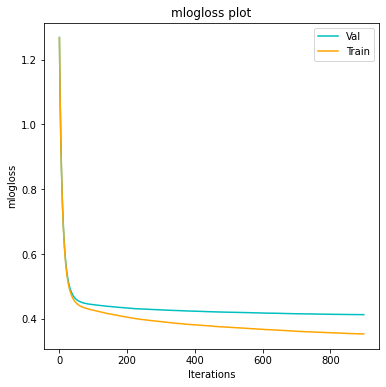

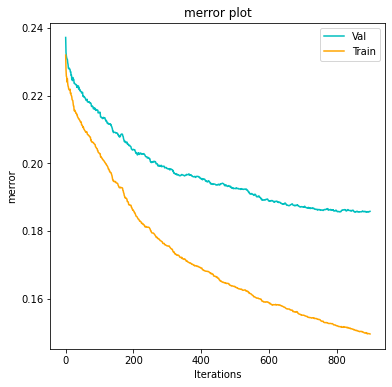

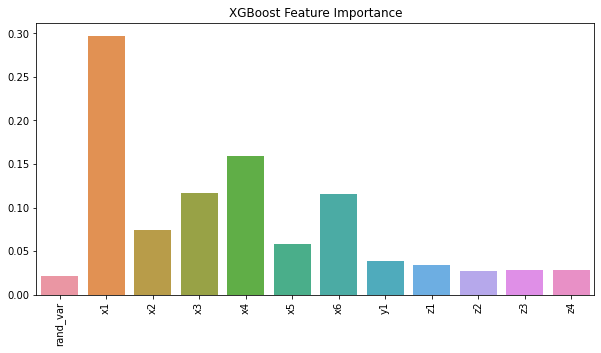

In [206]:
#fit our model with the 'fitXgb' funciton above which will give us some nice outputs

fitXgb(xgb2, training_data)

In [207]:
predicted_labels = xgb2.predict(training_data['X_test'])
    
print(classification_report(training_data['y_test'], predicted_labels))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     12781
           1       0.68      0.88      0.77      6861
           2       0.80      0.01      0.03       287
           3       0.00      0.00      0.00        71

    accuracy                           0.82     20000
   macro avg       0.60      0.43      0.41     20000
weighted avg       0.84      0.82      0.81     20000



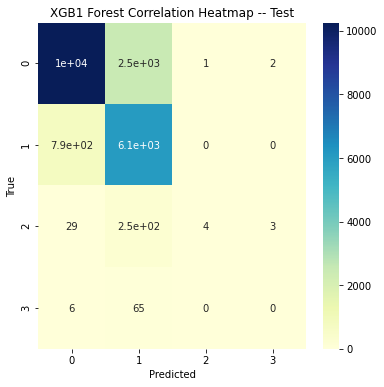

In [208]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test = training_data['y_test']
predicted_labels = xgb2.predict(training_data['X_test'])

CM = confusion_matrix(y_test, predicted_labels)

# Visualize it as a heatmap
import seaborn
ax = plt.axes()
sns.heatmap(CM,  cmap="YlGnBu", annot=True)

ax.set_title('XGB1 Forest Correlation Heatmap -- Test')
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.show()

In [209]:
#predict on test data and sample y_test data so lengths are equal
predict_on_test = xgb2.predict(training_data['X_test'])
y_train_sample = np.random.choice(training_data['y_test'], (20000,))

#hold data above as separate arrays
arr1 = predict_on_test
arr2 = y_train_sample

#convert zeros to 0.1 for entropy calculation. Otherwise 'inf' will be returned
result1 = np.where(arr1<=0, 0.1, arr1)
result2 = np.where(arr2<=0, 0.1, arr2)

#calculate entorpy
print('Entropy = ' + "" + str(entropy(result1, result2)))

Entropy = 1.0983445214244298


<div class="alert alert-block alert-warning">
There's not much of a difference between the two models but our entropy did go down just a little bit and our confusion matrix indicates that our minority classes are being predicted more accurately
</div>

<div class="alert alert-block alert-warning">
Let's take one more pass and give our model an array of weights with which to improve it's error calculation with regard to minority classes
</div>

In [408]:
#view proportion of classes

from collections import Counter
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
class0 = counter[0] / len(y)
print('Estimate: %.3f' % class0)

class1 = counter[1] / len(y)
print('Estimate: %.3f' % class1)

class2 = counter[2] / len(y)
print('Estimate: %.3f' % class2)

class3 = counter[3] / len(y)
print('Estimate: %.3f' % class3)

Estimate: 0.639
Estimate: 0.343
Estimate: 0.014
Estimate: 0.004


In [210]:
#calculate balanced class weights

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

C:\Users\wagneaj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=78007    0
61755    0
17252    0
25986    1
14850    0
        ..
3011     1
73436    1
92910    0
30012    0
25750    0
Name: label, Length: 80000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [216]:
from xgboost.sklearn import XGBClassifier
xgb3 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=4,
                    lamda=2,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=4,
                    seed=27)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.27188	val-merror:0.24685	train-mlogloss:1.2714	train-merror:0.245037
[100]	val-mlogloss:0.45644	val-merror:0.23	train-mlogloss:0.448335	train-merror:0.223513
[200]	val-mlogloss:0.44827	val-merror:0.2203	train-mlogloss:0.434924	train-merror:0.213038
[300]	val-mlogloss:0.444534	val-merror:0.21685	train-mlogloss:0.427208	train-merror:0.207687
[400]	val-mlogloss:0.442099	val-merror:0.21565	train-mlogloss:0.422021	train-merror:0.204725
[500]	val-mlogloss:0.439655	val-merror:0.2135	train-mlogloss:0.417254	train-merror:0.201587
[600]	val-mlogloss:0.437773	val-merror:0.21205	train-mlogloss:0.413332	train-merror:0.1975
[700]	val-mlogloss:0.436192	val-merror:0.21195	train-mlogloss:0.409504	train-merror:0.194975
[800]	val-mlogloss:0.434919	val-merror:0.2102	train-mlogloss:0.406404	train-merror:0.192675
[899]	val-mlogloss:0.433628	val-merror:0.20825	train-mlogloss:0.403619	train-merror:0.190012
-- Model Report --
XGBoost Accuracy: 0.6444
XGBoost F1

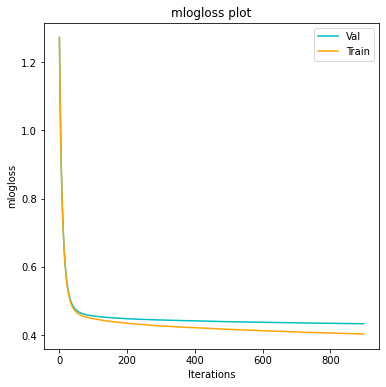

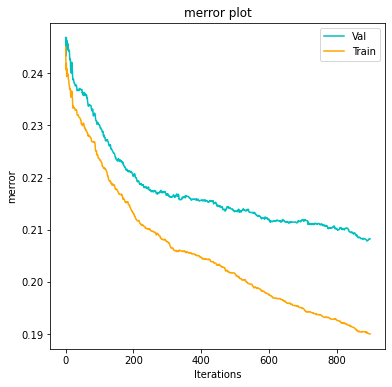

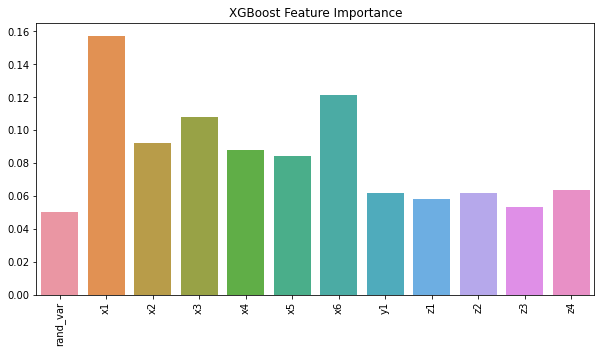

In [217]:
#fit our model with the 'fitXgb' funciton above which will give us some nice outputs

fitXgb(xgb3, training_data)

In [219]:
predicted_labels = xgb3.predict(training_data['X_test'])
    
print(classification_report(training_data['y_test'], predicted_labels))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12781
           1       0.86      0.02      0.03      6861
           2       0.00      0.00      0.00       287
           3       0.15      0.03      0.05        71

    accuracy                           0.64     20000
   macro avg       0.41      0.26      0.22     20000
weighted avg       0.71      0.64      0.51     20000



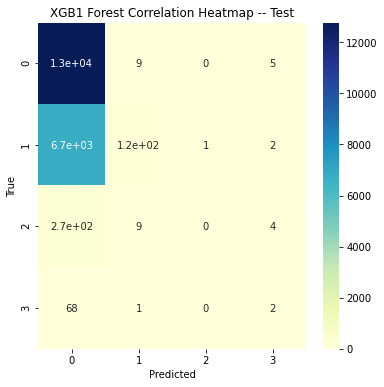

In [220]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test = training_data['y_test']
predicted_labels = xgb3.predict(training_data['X_test'])

CM = confusion_matrix(y_test, predicted_labels)

# Visualize it as a heatmap
import seaborn
ax = plt.axes()
sns.heatmap(CM,  cmap="YlGnBu", annot=True)

ax.set_title('XGB1 Forest Correlation Heatmap -- Test')
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.show()

In [228]:
#predict on test data and sample y_test data so lengths are equal
predict_on_test = xgb3.predict(training_data['X_test'])
y_train_sample = np.random.choice(training_data['y_test'], (20000,))

#hold data above as separate arrays
arr1 = predict_on_test
arr2 = y_train_sample

#convert zeros to 0.1 for entropy calculation. Otherwise 'inf' will be returned
result1 = np.where(arr1<=0, 0.1, arr1)
result2 = np.where(arr2<=0, 0.1, arr2)

#calculate entorpy
print('Entropy = ' + "" + str(entropy(result1, result2)))

Entropy = 0.7838514817330097


<div class="alert alert-block alert-warning">
Weighting with balance classes made things mostly worse save for the entropy which looks like it is improving mainly do to improved prediction of the '1' class
</div>

<div class="alert alert-block alert-warning">
It looks like so far our best model is 'xbg2'. Let's rerun that on our 'test' data set and then go over what we learned
</div>

In [229]:
#predict xgb2 on test data
predict_on_test = xgb2.predict(training_data['X_test'])

In [ ]:
#concatenate predictions with original dataframe and write out to .csv
predict_df = pd.DataFrame(predict_on_test)

#rename prediction column
predict_df.rename(columns={0: 'model_predict'}, inplace=True)

#concatenate with original 'test' dataframe
test_df_reset = test_df.reset_index()
predict_df_reset = predict_df.reset_index()

final_results_df = pd.concat([test_df_reset, predict_df_reset], axis=1)

In [245]:
#write to .csv
final_results_df.to_csv(r'C:\Users\wagneaj\Desktop\InterComp\oc_prediction.csv', index=False)

<div class="alert alert-block alert-info">
3. Summary Evaluation
</div>

<div class="alert alert-block alert-warning">
It looks like so far our best model is 'xbg2'. Let's rerun that on our 'test' data set and then go over what we learned<br>

1. Our model does a decent job at predicting based on the confusion matrix and f1 score; however, there is still a bit of work to be done on making sure the model does a better job of not 'underpredicting' values. Some things to try with a bit more time are as follows:  <br>
a. Tune hyperparameters using Gridsearch CV. From manually tuning our predictions it looks like optimizing our hyperparameters over a grid search space may improve our results some, particularly with regard to the regularization parameters of gamma and lamda <br>
b. Our class weights didn't do much for us but we also just tried one pass with those. We could also perform a grid search over the class weights to find the optimal weighting<br>
c. We might also try something a bit more creative like running a binary classifier over our minority classes; then running a multiclass classifier over the entire data set and for each row, taking the top prediction<br>
2. We may also just need a few more data points for the minority classes or we may need to engineer some additonal features. What may be happening is that the classes with which the model is getting confused may not be linearly separable in higher dimensions. Let's look at one more data exploration exercise to test this hypothesis
</div>

In [247]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

<div class="alert alert-block alert-warning">
We will be using the 'TSNE' library to map our data as clusters down into two dimensinos. First, we will use pca to reduce the number of dimensions; then we will cluster our data and map the results into two dimensions using 'TSNE'
</div>

In [251]:
#sample data frame so as not to overload 'TSNE'
np.random.seed(42)
rndperm = np.random.permutation(train_df.shape[0])

N = 10000

df_subset = train_df.loc[rndperm[:N],:].copy()
data_subset = df_subset.values

#create principal components and print the amount of information explained by each component
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.73762841 0.17592133 0.03941785]


In [253]:
#apply TSNE to usine the first two principal components for our axes
import time

time_start = time.time()

#run 'TSNE'
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.097s...
[t-SNE] Computed neighbors for 10000 samples in 0.719s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.021902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.064491
[t-SNE] KL divergence after 300 iterations: 2.134587
t-SNE done! Time elapsed:

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

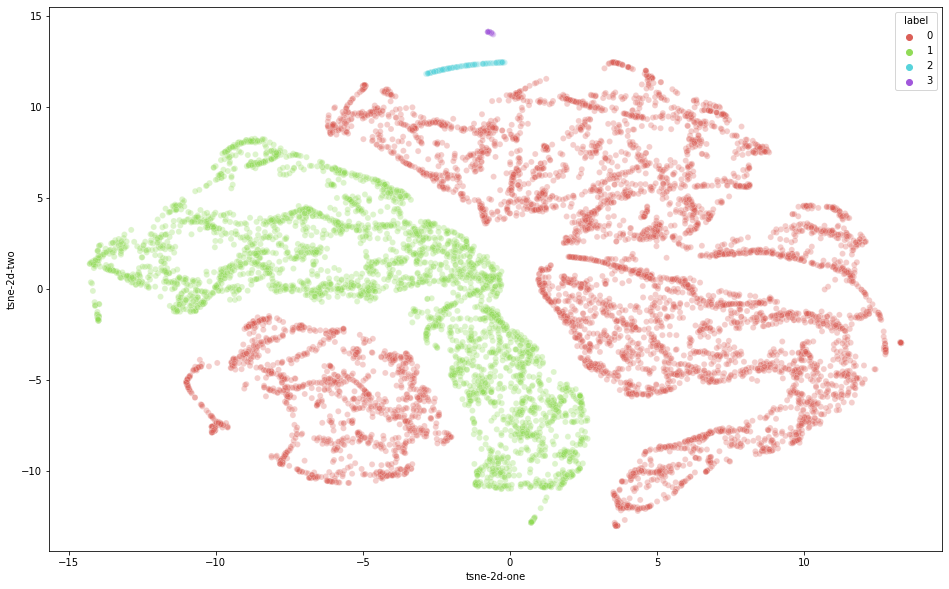

In [255]:
#plot results

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=df_subset,
    legend="full",
    alpha=0.3
)


<div class="alert alert-block alert-warning">
Interestingly, we can see above that the majority classes are very linearly separable which makes sense because our model performs well there. We can also see why sometimes our model gets confused between the '0' and '1' class. Additionally, by looking at the cluster for '2' and '3' we can see that, although separated, they do line up sometimes along the second principal component and are also located close to a portion of the '0' cluster. This fact is reflected in our confusion matrix where class '2' and class '3' are more often misclassified as '0' than as '1'
</div>